In [88]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from utils.code_exercise1 import my_window, get_fundamental_freq
from utils.code_exercise2 import compute_stft, compute_istft, plot_spectrum
from scipy.signal import get_window
import sounddevice

In [2]:
y, sr = librosa.core.load("data/exercise7/noisySensor.wav", sr=None, mono=False)

In [3]:
frame_length = 128
frame_shift = 32
n_length = int(sr * frame_length / 1000) 
n_shift = int(sr * frame_shift / 1000)
total_segments = 1 + (y.shape[1] - n_length) // n_shift
hann_win = get_window('hann', n_length)
sqrt_hann_win = np.sqrt(hann_win)

In [4]:
res = np.apply_along_axis(compute_stft, 1,y, sr, frame_length, frame_shift, sqrt_hann_win)


In [74]:
Y = res[:,0] * 0.5
Y = np.stack(Y)
v_freq = res[0,1]
v_time = res[0,2]

In [75]:
d = 0.05
theta = np.pi / 4
c = 340
M = 4
N = v_freq.shape[0] + 1
time_delays = np.array([ i*d*np.cos(theta) / c for i in range(M)])

In [76]:
time_delays

array([0.        , 0.00010399, 0.00020797, 0.00031196])

In [77]:
a_coef = np.array([ np.exp(-1j * 2 * np.pi * i /N * sr * time_delays[i]) for i in range(M)])

In [100]:
S = []
for i, a in enumerate(a_coef):
    S.append(a.conj().T * Y[i] / M)
S = np.array(S)

In [101]:
S.shape

(4, 210, 1025)

In [102]:
S = S.sum(0)

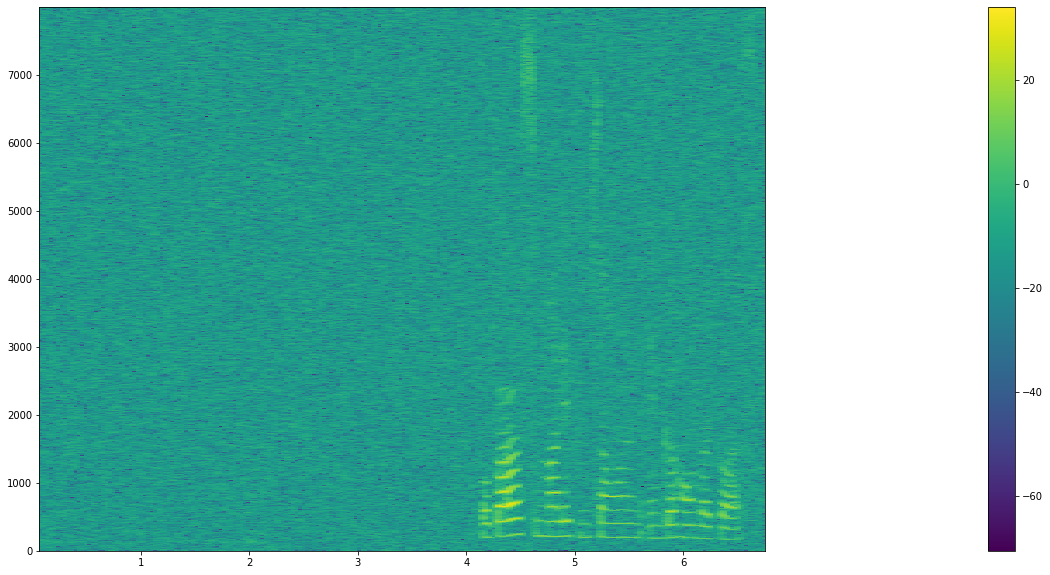

In [103]:
plot_spectrum(Y[0], v_freq, v_time)

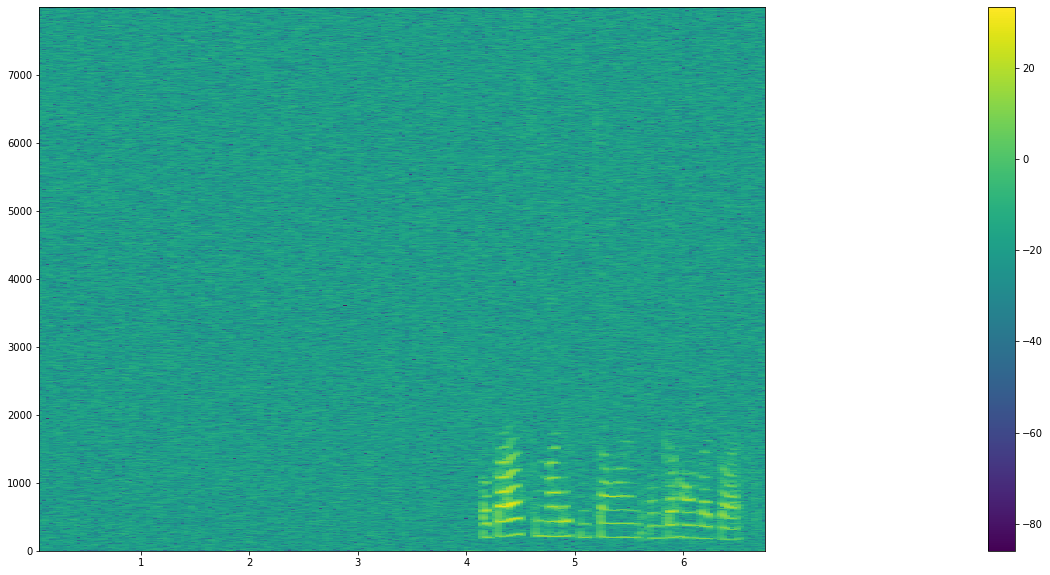

In [104]:
plot_spectrum(S, v_freq, v_time)

In [105]:
y_clean = compute_istft(S, sr, frame_shift, sqrt_hann_win)

In [156]:
sounddevice.play(y_clean, samplerate=sr)

In [107]:
sounddevice.play(y[0], samplerate=sr)

## MVDR

In [121]:
L = 5
noise = Y[0,:L].sum(0) / L

In [122]:
phi = np.cov(noise, noise.conj().T)

In [141]:
a_coef.reshape(-1,1)

array([[1.        +0.j        ],
       [0.99994799-0.01019869j],
       [0.99916798-0.04078417j],
       [0.99579027-0.09166099j]])

In [148]:
h = np.linalg.solve(phi, a_coef.reshape(2,2)).reshape(M)

In [150]:
S_mvdr = []
for i, h_val in enumerate(h):
    S_mvdr.append(h_val.conj().T * Y[i] )
S_mvdr = np.array(S)

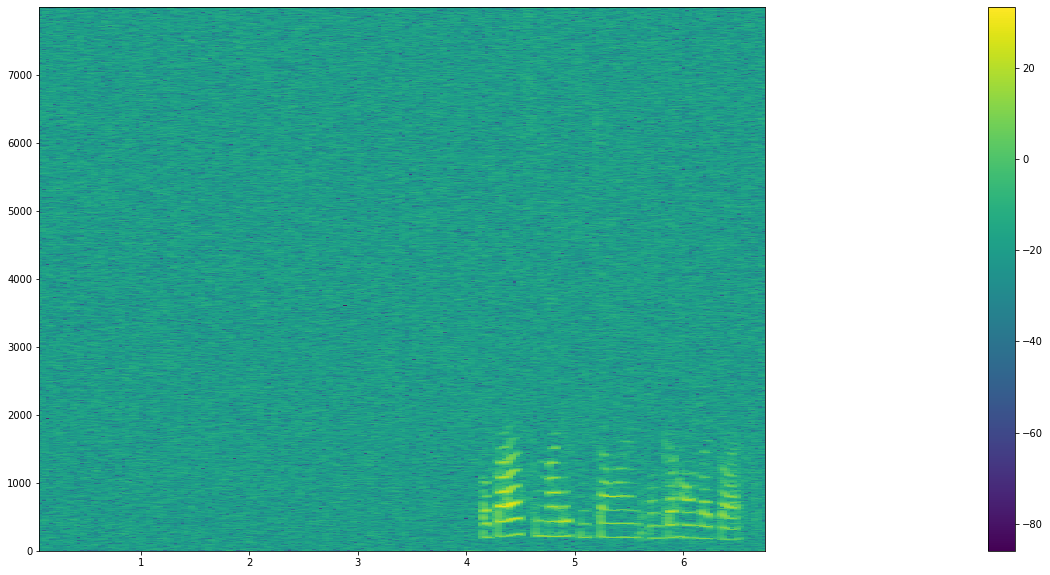

In [153]:
plot_spectrum(S_mvdr, v_freq, v_time)

In [154]:
y_mvdr = compute_istft(S_mvdr, sr, frame_shift, sqrt_hann_win)

In [155]:
sounddevice.play(y_mvdr, samplerate=sr)